In [259]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [260]:
df = pd.read_csv('data.csv')
df = df[['Date/Time', 'Total Precip (in)']]
df['Date/Time'] = pd.to_datetime(df['Date/Time'])
df.set_index('Date/Time', inplace=True)
df = df.fillna(0)

daily_precip = df['Total Precip (in)'].resample('D').sum()

daily_precip = pd.DataFrame(daily_precip)

daily_precip.head()

,Total Precip (in)
Date/Time,
2020-01-01,0.04
2020-01-02,0.00
2020-01-03,0.00
2020-01-04,0.00
2020-01-05,0.24


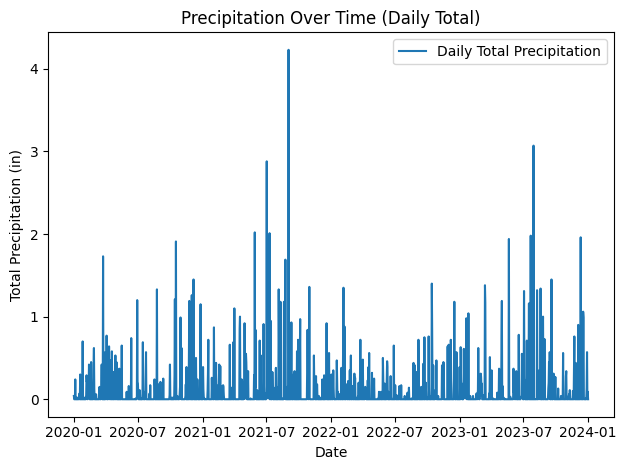

In [261]:
plt.plot(daily_precip, label='Daily Total Precipitation')
plt.xlabel('Date')
plt.ylabel('Total Precipitation (in)')
plt.title('Precipitation Over Time (Daily Total)')
plt.legend()
plt.tight_layout()
plt.show()

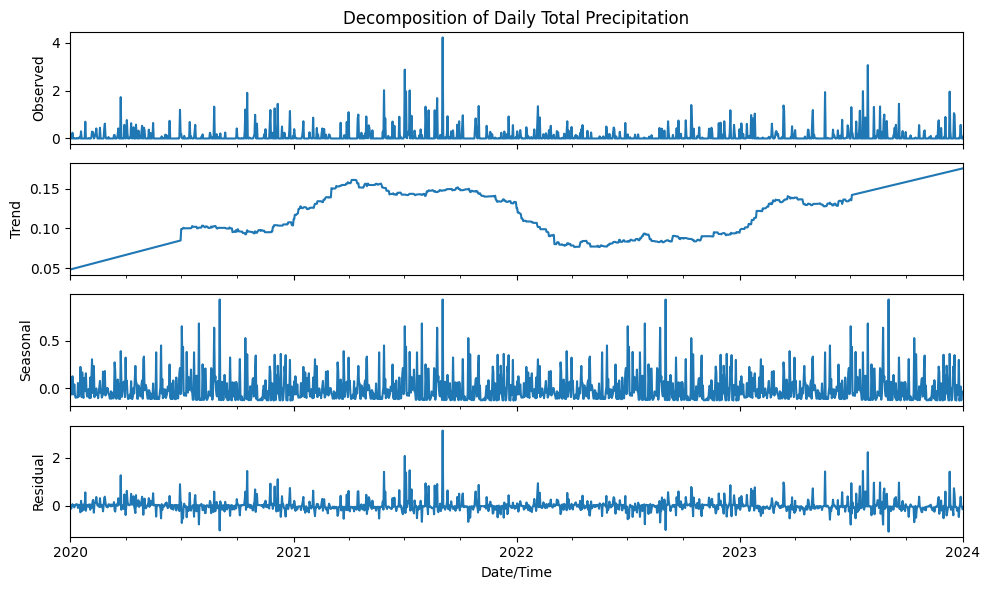

In [262]:
decomposition = seasonal_decompose(daily_precip, model='additive', period=365, extrapolate_trend='freq')

fig, ax = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(10, 6))
ax[0].set_title('Decomposition of Daily Total Precipitation')
decomposition.observed.plot(ax=ax[0], legend=False)
ax[0].set_ylabel('Observed')

decomposition.trend.plot(ax=ax[1], legend=False)
ax[1].set_ylabel('Trend')

decomposition.seasonal.plot(ax=ax[2], legend=False)
ax[2].set_ylabel('Seasonal')

decomposition.resid.plot(ax=ax[3], legend=False)
ax[3].set_ylabel('Residual')

plt.tight_layout()
plt.show()

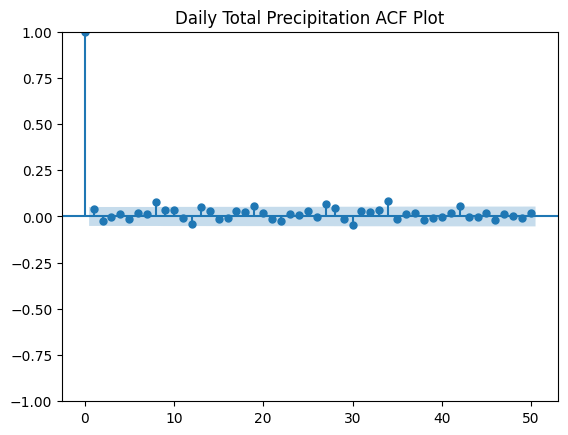

In [263]:
plot_acf(daily_precip, title='Daily Total Precipitation ACF Plot', lags=50)
plt.show()

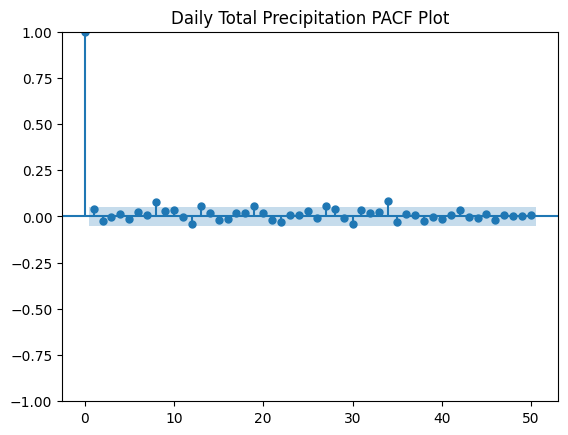

In [264]:
plot_pacf(daily_precip, title='Daily Total Precipitation PACF Plot', lags=50)
plt.show()

In [265]:
precip_array = daily_precip.values.reshape(-1, 1)

train_size = int(0.8 * len(precip_array))
y_train = precip_array[:train_size]
y_test = precip_array[train_size:]

In [266]:
y_train_flat = y_train.flatten()
ar_model = AutoReg(y_train_flat, lags=2, trend='n')
ar_results = ar_model.fit()

print(ar_results.summary())
print("Roots:", ar_results.roots)

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                 1169
Model:                     AutoReg(2)   Log Likelihood                -298.957
Method:               Conditional MLE   S.D. of innovations              0.313
Date:                Tue, 08 Apr 2025   AIC                            603.915
Time:                        16:57:45   BIC                            619.101
Sample:                             2   HQIC                           609.643
                                 1169                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
y.L1           0.1374      0.029      4.676      0.000       0.080       0.195
y.L2           0.0956      0.029      3.253      0.001       0.038       0.153
                                    Roots           

In [267]:
ar_pred = ar_results.predict(
    start=len(y_train), 
    end=len(y_train) + len(y_test) - 1
)

test_index = daily_precip.index[len(y_train):len(y_train) + len(y_test)]

pred_data = pd.DataFrame({
    'Date': test_index,
    'Predicted Precipitation': ar_pred.flatten()
}).set_index('Date')

pred_data.head()

,Predicted Precipitation
Date,
2023-03-15,0.189637
2023-03-16,0.157971
2023-03-17,0.039835
2023-03-18,0.020574
2023-03-19,0.006635


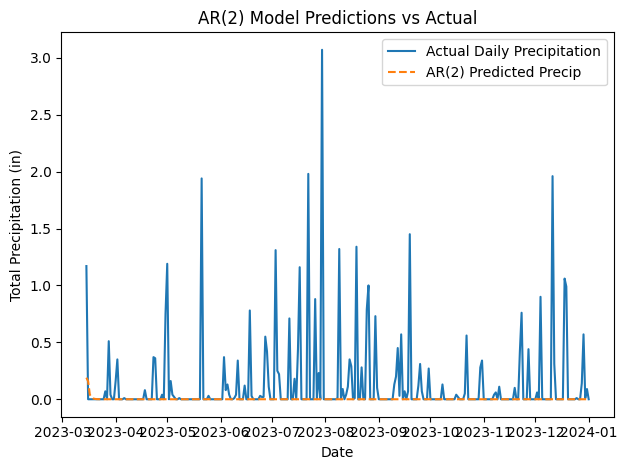

In [268]:
actual_test = pd.Series(
    y_test.flatten(), 
    index=daily_precip.index[len(y_train):len(y_train) + len(y_test)]
)

plt.plot(actual_test, label='Actual Daily Precipitation')
plt.plot(pred_data['Predicted Precipitation'], label='AR(2) Predicted Precip', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Total Precipitation (in)')
plt.title('AR(2) Model Predictions vs Actual')
plt.legend()
plt.tight_layout()
plt.show()

In [269]:
y_pred = pred_data['Predicted Precipitation'].values

ararmae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f'Mean Absolute Error: {ararmae:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')

Mean Absolute Error: 0.14
Root Mean Squared Error: 0.39


In [270]:
ma_model = ARIMA(y_train, order=(0, 0, 2))
ma_results = ma_model.fit()

print(ma_results.summary())
print("MA Roots:", ma_results.maroots)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1169
Model:                 ARIMA(0, 0, 2)   Log Likelihood                -242.357
Date:                Tue, 08 Apr 2025   AIC                            492.714
Time:                        16:57:46   BIC                            512.970
Sample:                             0   HQIC                           500.354
                               - 1169                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1095      0.015      7.504      0.000       0.081       0.138
ma.L1          0.0371      0.034      1.085      0.278      -0.030       0.104
ma.L2         -0.0057      0.016     -0.354      0.7

In [271]:
ma_pred = ma_results.predict(
    start=len(y_train),
    end=len(y_train) + len(y_test) - 1
)

test_index = daily_precip.index[len(y_train):len(y_train) + len(y_test)]

pred_data = pd.DataFrame({
    'Date': test_index,
    'Predicted Precipitation': ma_pred.flatten()
}).set_index('Date')

pred_data.head()

,Predicted Precipitation
Date,
2023-03-15,0.157331
2023-03-16,0.102199
2023-03-17,0.109498
2023-03-18,0.109498
2023-03-19,0.109498


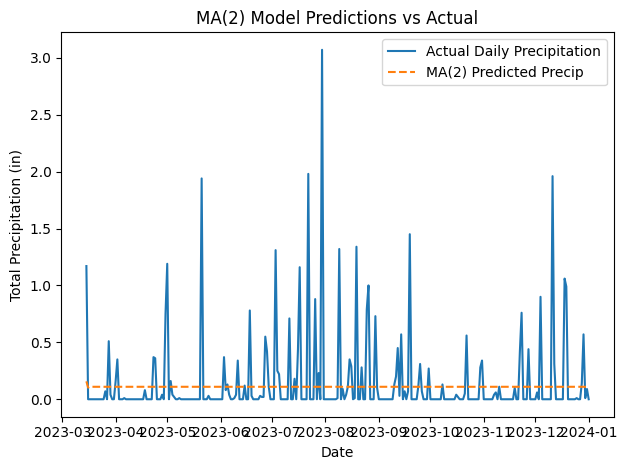

In [272]:
actual_test = pd.Series(
    y_test.flatten(),
    index=daily_precip.index[len(y_train):len(y_train) + len(y_test)]
)

plt.plot(actual_test, label='Actual Daily Precipitation')
plt.plot(pred_data['Predicted Precipitation'], label='MA(2) Predicted Precip', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Total Precipitation (in)')
plt.title('MA(2) Model Predictions vs Actual')
plt.legend()
plt.tight_layout()
plt.show()

In [273]:
y_pred = pred_data['Predicted Precipitation'].values

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f'Mean Absolute Error: {mae:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')

Mean Absolute Error: 0.19
Root Mean Squared Error: 0.37


In [274]:
arma_model = ARIMA(y_train, order=(2, 0, 2))
arma_results = arma_model.fit()

print(arma_results.summary())

print("AR Roots:", arma_results.arroots)
print("MA Roots:", arma_results.maroots)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1169
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -239.433
Date:                Tue, 08 Apr 2025   AIC                            490.866
Time:                        16:57:48   BIC                            521.250
Sample:                             0   HQIC                           502.326
                               - 1169                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1114      0.028      4.049      0.000       0.057       0.165
ar.L1          0.0756      0.156      0.486      0.627      -0.229       0.381
ar.L2          0.8992      0.150      6.001      0.0

/Users/ma/Documents/GitHub/WeatherPrediction/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [275]:
arma_pred = arma_results.predict(
    start=len(y_train),
    end=len(y_train) + len(y_test) - 1
)

test_index = daily_precip.index[len(y_train):len(y_train) + len(y_test)]

pred_data = pd.DataFrame({
    'Date': test_index,
    'Predicted Precipitation': arma_pred.flatten()
}).set_index('Date')

pred_data.head()

,Predicted Precipitation
Date,
2023-03-15,0.131672
2023-03-16,0.105789
2023-03-17,0.129203
2023-03-18,0.107700
2023-03-19,0.127126


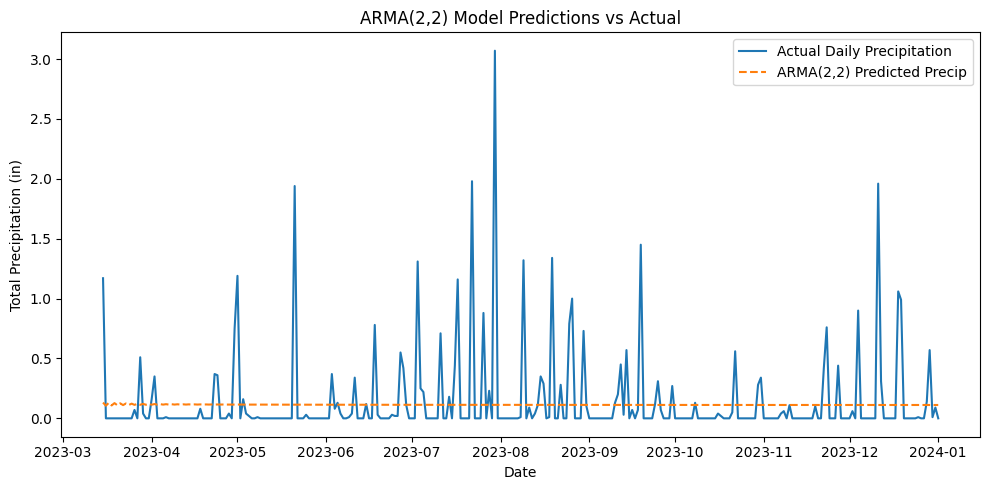

In [276]:
actual_test = pd.Series(
    y_test.flatten(),
    index=daily_precip.index[len(y_train):len(y_train) + len(y_test)]
)

plt.figure(figsize=(10, 5))
plt.plot(actual_test, label='Actual Daily Precipitation')
plt.plot(pred_data['Predicted Precipitation'], label='ARMA(2,2) Predicted Precip', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Total Precipitation (in)')
plt.title('ARMA(2,2) Model Predictions vs Actual')
plt.legend()
plt.tight_layout()
plt.show()

In [277]:
y_pred = pred_data['Predicted Precipitation'].values

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f'Mean Absolute Error: {mae:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')

Mean Absolute Error: 0.19
Root Mean Squared Error: 0.37
